In [1]:
# RDKit packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors


# RDKit descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation

#from xgboost import XGBClassifier
#import lightgbm as lgbm

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/btatsis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


                 smiles  solubility  logp
0  c1ccccc1c2cc(Cl)ccc2       -4.88  4.40
1  O=N(=O)c(c(ccc1)C)c1       -2.33  2.36
2          CC(O)CCC(C)C       -1.38  2.17
The Huuskonsen data set contains  1297  compounds


,smiles,solubility,logp,ROMol,MW,HeavyAtomCount,RingCount,TPSA
0,c1ccccc1c2cc(Cl)ccc2,-4.88,4.4,,188.657,13,2,0.0

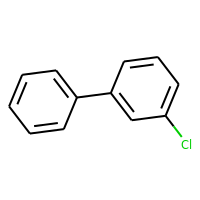

In [13]:
#Read solubility data
sol_data = pd.read_csv('datasets/huuskonsen_data.csv')
print(sol_data.head(n=3))

def estate_fingerprint_and_mw(mol):
    return np.append(FingerprintMol(mol)[0], Descriptors.MolWt(x))

#Add some new columns
sol_data['ROMol'] = sol_data['smiles'].apply(Chem.MolFromSmiles)
print("The Huuskonsen data set contains ", len(sol_data), " compounds")

# Adding a few more descriptors (MW, HAC, RingCount, and TPSA)
# Althought, in this project we will use only the structural fingerprints 
# to calculate a small molecule's logp
sol_data['MW']             = sol_data['ROMol'].map(Descriptors.MolWt)
sol_data['HeavyAtomCount'] = sol_data['ROMol'].map(Descriptors.HeavyAtomCount)
sol_data['RingCount']      = sol_data['ROMol'].map(Descriptors.RingCount)
sol_data['TPSA']           = sol_data['ROMol'].map(Descriptors.TPSA)

# Add Chemical structure to Pandas frame
PandasTools.AddMoleculeColumnToFrame(sol_data,smilesCol='smiles',molCol='ROMol',includeFingerprints=True)

# Target values
y = sol_data['solubility'].values
sol_data.head(n=1)

Converting Estate fingerprints
Converting Morgan fingerprints
Converting RDKit fingerprints
Converting Topological torsion fingerprints
Converting Extended reduced graph approach fingerprints
Converting Avalon bit based fingerprints


,smiles,solubility,logp,ROMol,MW,HeavyAtomCount,RingCount,TPSA,fp_estate,fp_Morgan,fp_RDKit,fp_Torsion,fp_ErG,AV_Torsion,fp_Avalon
0,c1ccccc1c2cc(Cl)ccc2,-4.88,4.4,,188.657,13,2,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...]","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"

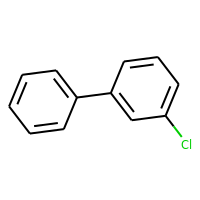

In [34]:
print("Converting Estate fingerprints")

# Estate fingerprints
def estate_fingerprint(mol):
    return FingerprintMol(mol)[0]

sol_data['fp_estate'] = sol_data['ROMol'].apply(estate_fingerprint)

print("Converting Morgan fingerprints")

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

sol_data['fp_Morgan'] = sol_data['ROMol'].apply(Morgan_fingerprint)

print("Converting RDKit fingerprints")

# RDKit fingerprints, length 1024 bits
def RDKit_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(RDKFingerprint(mol, 2, fpSize = 1024), fp)
    return fp

sol_data['fp_RDKit'] = sol_data['ROMol'].apply(RDKit_fingerprint)

print("Converting Topological torsion fingerprints")

# Topological torsion (1987), length 1024 bits
def Torsion_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits = 1024), fp)
    return fp

sol_data['fp_Torsion'] = sol_data['ROMol'].apply(RDKit_fingerprint)

print("Converting Extended reduced graph approach fingerprints")

# ErG (Extended reduced graph approach) fingerprints (2006)
# Create by researchers in Eli Lilly 
# http://pubs.acs.org/doi/abs/10.1021/ci050457y
def ErG_fingerprint(mol):
    return GetErGFingerprint(mol)

sol_data['fp_ErG'] = sol_data['ROMol'].apply(ErG_fingerprint)

print ("Converting Avalon bit based fingerprints")

# Avalon bit based (2006), length 1024 bits
def Avalon_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetAvalonFP(mol, nBits = 1024), fp)
    return fp

sol_data['fp_Avalon'] = sol_data['ROMol'].apply(Avalon_fingerprint)

sol_data.head(n=1)

In [35]:
#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'fp_Torsion', 'fp_ErG', 'fp_Avalon']
fps = ['fp_Morgan']
print sol_data[]

def test_model_cv(model, x, y, cv=20):
    scores = cross_validation.cross_val_score(model, x, y, cv=cv, n_jobs=-1, 
                                              scoring='neg_mean_absolute_error')

    return -1 * scores.mean()


def test_fingerprints(fps, model, y, verbose = True):

    fps_score = {}

    for fp in fps:
        x = sol_data[fp]
        if verbose: print("Generating ", fp, "fingerprints")
        fps_score[fp] = test_model_cv(model, x, y)

    fps_sorted = sorted(fps_score, key=fingerprint_scores.__getitem__, reverse=False)

    #print("\n Using Linear Regression Model: ", model)
    print("          ----------------------------------")
    print("                name        CV avg abs error")
    print("          ----------------------------------")
    for i in range(len(fps_sorted)):
        name = fps_sorted[i]
        print("%26s    %5.3f " % (name, fps_score[name]))
    print("          ----------------------------------")

# Tikhonov estimation
test_fingerprints(fps, BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-03, alpha_2=1e-03, lambda_1=1e-03, lambda_2=1e-03), y, verbose=True)
test_fingerprints(fps, Ridge(alpha=1e-3), y, verbose=True)

Generating  fp_Morgan fingerprints


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/btatsis/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f99dec78a50, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/btatsis/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/btatsi.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f99dec78a50, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/btatsis/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/btatsi.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(12, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(12, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (12, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=12, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 21, 17, 34, 53, 396720, tzinfo=tzutc()), 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'session': '8830169ace7cbd41320ef6d4f9d3d29a', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8830169ace7cbd41320ef6d4f9d3d29a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 21, 17, 34, 53, 396720, tzinfo=tzutc()), 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'session': '8830169ace7cbd41320ef6d4f9d3d29a', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8830169ace7cbd41320ef6d4f9d3d29a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 21, 17, 34, 53, 396720, tzinfo=tzutc()), 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'session': '8830169ace7cbd41320ef6d4f9d3d29a', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '764d5dc837c8c4c2d4e16301bbbe138d', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'f...erprints(fps, Ridge(alpha=1e-3), y, verbose=True)", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.FunctionDef object>, <_ast.FunctionDef object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-35-093f16f1123c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f9980c30c18, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f997de95930, file "<ipython-input-35-093f16f1123c>", line 32>
        result = <ExecutionResult object at 7f9980c30c18, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f997de95930, file "<ipython-input-35-093f16f1123c>", line 32>, result=<ExecutionResult object at 7f9980c30c18, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f997de95930, file "<ipython-input-35-093f16f1123c>", line 32>
        self.user_global_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'AllChem': <module 'rdkit.Chem.AllChem' from '/home/btatsis...b/python3.6/site-packages/rdkit/Chem/AllChem.py'>, 'Avalon_fingerprint': <function Avalon_fingerprint>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'Chem': <module 'rdkit.Chem' from '/home/btatsis/anacond.../python3.6/site-packages/rdkit/Chem/__init__.py'>, 'ConvertToNumpyArray': <Boost.Python.function object>, 'Dense': <class 'keras.layers.core.Dense'>, 'Descriptors': <module 'rdkit.Chem.Descriptors' from '/home/bta...thon3.6/site-packages/rdkit/Chem/Descriptors.py'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'ErG_fingerprint': <function ErG_fingerprint>, ...}
        self.user_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'AllChem': <module 'rdkit.Chem.AllChem' from '/home/btatsis...b/python3.6/site-packages/rdkit/Chem/AllChem.py'>, 'Avalon_fingerprint': <function Avalon_fingerprint>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'Chem': <module 'rdkit.Chem' from '/home/btatsis/anacond.../python3.6/site-packages/rdkit/Chem/__init__.py'>, 'ConvertToNumpyArray': <Boost.Python.function object>, 'Dense': <class 'keras.layers.core.Dense'>, 'Descriptors': <module 'rdkit.Chem.Descriptors' from '/home/bta...thon3.6/site-packages/rdkit/Chem/Descriptors.py'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'ErG_fingerprint': <function ErG_fingerprint>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/btatsis/projects/MLND/CapStoneProject/<ipython-input-35-093f16f1123c> in <module>()
     27         name = fps_sorted[i]
     28         print("%26s    %5.3f " % (name, fps_score[name]))
     29     print("          ----------------------------------")
     30 
     31 # Tikhonov estimation
---> 32 test_fingerprints(fps, BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-03, alpha_2=1e-03, lambda_1=1e-03, lambda_2=1e-03), y, verbose=True)
     33 test_fingerprints(fps, Ridge(alpha=1e-3), y, verbose=True)

...........................................................................
/home/btatsis/projects/MLND/CapStoneProject/<ipython-input-35-093f16f1123c> in test_fingerprints(fps=['fp_Morgan'], model=BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), y=array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), verbose=True)
     13     fps_score = {}
     14 
     15     for fp in fps:
     16         x = sol_data[fp]
     17         if verbose: print("Generating ", fp, "fingerprints")
---> 18         fps_score[fp] = test_model_cv(model, x, y)
     19 
     20     fps_sorted = sorted(fps_score, key=fingerprint_scores.__getitem__, reverse=False)
     21 
     22     #print("\n Using Linear Regression Model: ", model)

...........................................................................
/home/btatsis/projects/MLND/CapStoneProject/<ipython-input-35-093f16f1123c> in test_model_cv(model=BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), x=0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, y=array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), cv=20)
      1 #fps = ['fp_estate', 'fp_Morgan', 'fp_RDKit', 'fp_Torsion', 'fp_ErG', 'fp_Avalon']
      2 fps = ['fp_Morgan']
      3 
      4 def test_model_cv(model, x, y, cv=20):
      5     scores = cross_validation.cross_val_score(model, x, y, cv=cv, n_jobs=-1, 
----> 6                                               scoring='neg_mean_absolute_error')
      7 
      8     return -1 * scores.mean()
      9 
     10 

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in cross_val_score(estimator=BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), X=0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, y=array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), scoring='neg_mean_absolute_error', cv=sklearn.cross_validation.KFold(n=1297, n_folds=20, shuffle=False, random_state=None), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1576     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1577                         pre_dispatch=pre_dispatch)
   1578     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1579                                               train, test, verbose, None,
   1580                                               fit_params)
-> 1581                       for train, test in cv)
        cv = sklearn.cross_validation.KFold(n=1297, n_folds=20, shuffle=False, random_state=None)
   1582     return np.array(scores)[:, 0]
   1583 
   1584 
   1585 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon May 21 18:34:58 2018
PID: 3496                 Python 3.6.5: /home/btatsis/anaconda3/bin/python3
...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), 0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), make_scorer(mean_absolute_error, greater_is_better=False), array([  65,   66,   67, ..., 1294, 1295, 1296]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), 0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), make_scorer(mean_absolute_error, greater_is_better=False), array([  65,   66,   67, ..., 1294, 1295, 1296]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), X=0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, y=array([-4.88, -2.33, -1.38, ..., -0.8 , -2.48, -3.27]), scorer=make_scorer(mean_absolute_error, greater_is_better=False), train=array([  65,   66,   67, ..., 1294, 1295, 1296]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1670 
   1671     try:
   1672         if y_train is None:
   1673             estimator.fit(X_train, **fit_params)
   1674         else:
-> 1675             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BayesianRidge.fit of BayesianRidge...      normalize=False, tol=0.001, verbose=False)>
        X_train = 65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object
        y_train = array([-3.55, -1.52, -3.04, ..., -0.8 , -2.48, -3.27])
        fit_params = {}
   1676 
   1677     except Exception as e:
   1678         if error_score == 'raise':
   1679             raise

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/bayes.py in fit(self=BayesianRidge(alpha_1=0.001, alpha_2=0.001, comp...       normalize=False, tol=0.001, verbose=False), X=65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, y=array([-3.55, -1.52, -3.04, ..., -0.8 , -2.48, -3.27]))
    152 
    153         Returns
    154         -------
    155         self : returns an instance of self.
    156         """
--> 157         X, y = check_X_y(X, y, dtype=np.float64, y_numeric=True)
        X = 65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object
        y = array([-3.55, -1.52, -3.04, ..., -0.8 , -2.48, -3.27])
    158         X, y, X_offset_, y_offset_, X_scale_ = self._preprocess_data(
    159             X, y, self.fit_intercept, self.normalize, self.copy_X)
    160         self.X_offset_ = X_offset_
    161         self.X_scale_ = X_scale_

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, y=array([-3.55, -1.52, -3.04, ..., -0.8 , -2.48, -3.27]), accept_sparse=False, dtype=<class 'numpy.float64'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=True, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object, accept_sparse=False, dtype=<class 'numpy.float64'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    428 
    429     if sp.issparse(array):
    430         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    431                                       force_all_finite)
    432     else:
--> 433         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array = 65      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,....0, 0.0, 0.0, ...]
Name: fp_Morgan, dtype: object
        dtype = <class 'numpy.float64'>
        order = None
        copy = False
    434 
    435         if ensure_2d:
    436             if array.ndim == 1:
    437                 raise ValueError(

ValueError: setting an array element with a sequence.
___________________________________________________________________________